# TODO: update with optimized model hyperparameters

this notebook will have clean functions that can be run on all course datasets
- perform a set of EDA operations and plots
- run the final version of the feature importance code
- run final models show the optimized output metrics (for NN, also plots accuracy over epochs and NN architecture)
- learning curves
- check them for underfit/overfit by plotting training error vs test error
- calculate precision/recall/accuracy/f1 scores for each
- plot AUC, ROC
- plot of model training time vs f1? idk just a query

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import accuracy_score, classification_report

In [6]:
FIT_THRESHOLD = 0.05  # Set a 5% threshold for acceptable difference

In [ ]:
def test_model_fit(X_train, y_train, X_test, y_test):
    # Define a list of models
    models = {
        'Logistic Regression': LogisticRegression(),
        'KNN': KNeighborsClassifier(),
        'Naive Bayes': GaussianNB(),
        'SVC': SVC()
        # 'Neural Network': KerasClassifier()
    }

    # Dictionary to store performance metrics
    train_scores = {}
    test_scores = {}

    # Train and evaluate each model
    for name, model in models.items():
        # Fit the model
        model.fit(X_train, y_train)
        
        # Get predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Compute accuracy for both training and testing
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        
        # Store the accuracy
        train_scores[name] = train_acc
        test_scores[name] = test_acc
        
        # Print the performance for each model
        print(f"{name}:")
        print(f"  Training Accuracy: {train_acc:.4f}")
        print(f"  Testing Accuracy: {test_acc:.4f}")
        
        # Check if overfitting or underfitting
        if abs(train_acc - test_acc) <= FIT_THRESHOLD:
            print(f"  Model is performing well on both training and test data.\n")
        elif train_acc - test_acc > FIT_THRESHOLD:
            print(f"  Model is likely overfitting.")
        elif test_acc - train_acc > FIT_THRESHOLD:
            print(f"  Model is likely underfitting.")

        print("\nClassification report on the test set:")
        print(classification_report(y_test, y_test_pred))


    # Visualize the results with a bar plot
    model_names = list(models.keys())
    train_values = list(train_scores.values())
    test_values = list(test_scores.values())

    x = np.arange(len(model_names))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))

    rects1 = ax.bar(x - width/2, train_values, width, label='Train')
    rects2 = ax.bar(x + width/2, test_values, width, label='Test')

    # Add some text for labels, title and custom x-axis tick labels
    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy')
    ax.set_title('Model Performance: Training vs Testing')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.legend()

    # Show the plot
    plt.show()


=============== business ===============
Logistic Regression:
  Training Accuracy: 0.8960
  Testing Accuracy: 0.8930
  Model is performing well on both training and test data.

KNN:
  Training Accuracy: 0.9140
  Testing Accuracy: 0.8837
  Model is performing well on both training and test data.

Naive Bayes:
  Training Accuracy: 0.8960
  Testing Accuracy: 0.8930
  Model is performing well on both training and test data.

SVC:
  Training Accuracy: 0.8960
  Testing Accuracy: 0.8930
  Model is performing well on both training and test data.



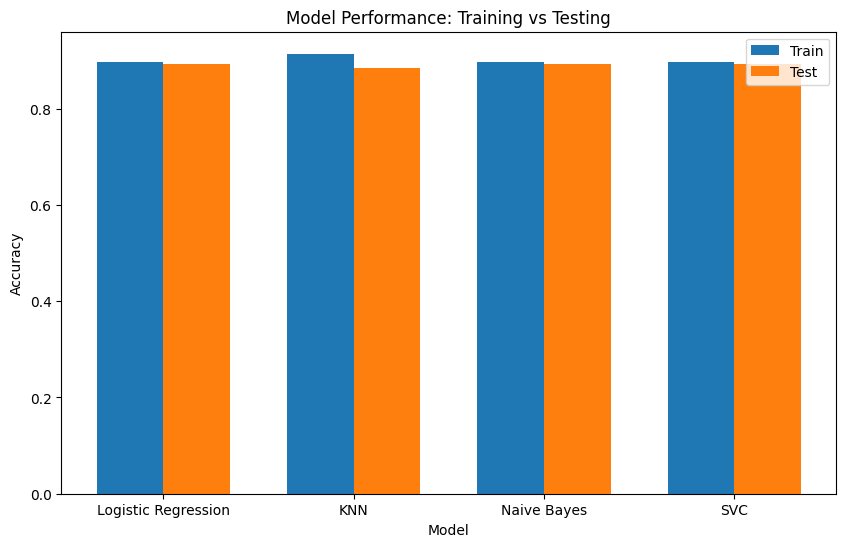



=============== compsci ===============
Logistic Regression:
  Training Accuracy: 0.7497
  Testing Accuracy: 0.7231
  Model is performing well on both training and test data.

KNN:
  Training Accuracy: 0.7818
  Testing Accuracy: 0.6678
  Model is likely overfitting.
Naive Bayes:
  Training Accuracy: 0.7497
  Testing Accuracy: 0.7231
  Model is performing well on both training and test data.

SVC:
  Training Accuracy: 0.7497
  Testing Accuracy: 0.7231
  Model is performing well on both training and test data.



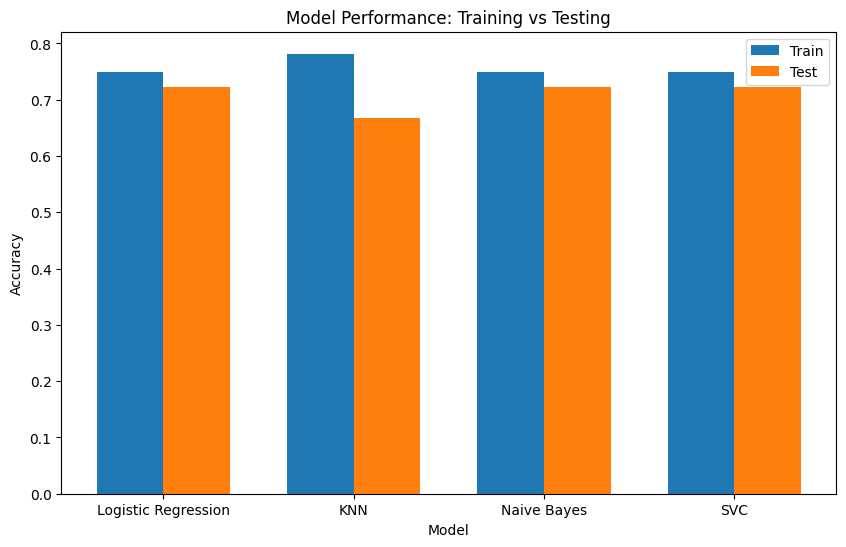



=============== engineering ===============
Logistic Regression:
  Training Accuracy: 0.9196
  Testing Accuracy: 0.8785
  Model is performing well on both training and test data.

KNN:
  Training Accuracy: 0.9196
  Testing Accuracy: 0.8785
  Model is performing well on both training and test data.

Naive Bayes:
  Training Accuracy: 0.9196
  Testing Accuracy: 0.8785
  Model is performing well on both training and test data.

SVC:
  Training Accuracy: 0.9196
  Testing Accuracy: 0.8785
  Model is performing well on both training and test data.



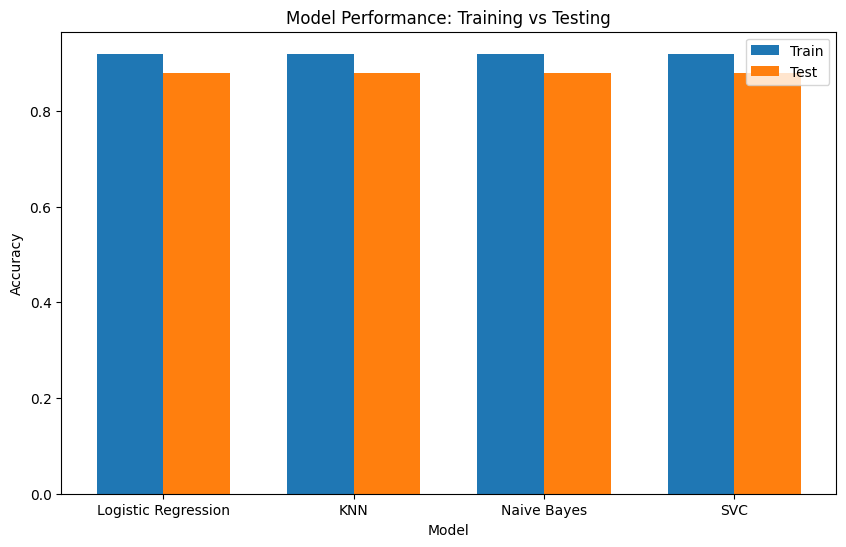



=============== law ===============
Logistic Regression:
  Training Accuracy: 0.9017
  Testing Accuracy: 0.9084
  Model is performing well on both training and test data.

KNN:
  Training Accuracy: 0.9017
  Testing Accuracy: 0.9012
  Model is performing well on both training and test data.

Naive Bayes:
  Training Accuracy: 0.9017
  Testing Accuracy: 0.9084
  Model is performing well on both training and test data.

SVC:
  Training Accuracy: 0.9017
  Testing Accuracy: 0.9084
  Model is performing well on both training and test data.



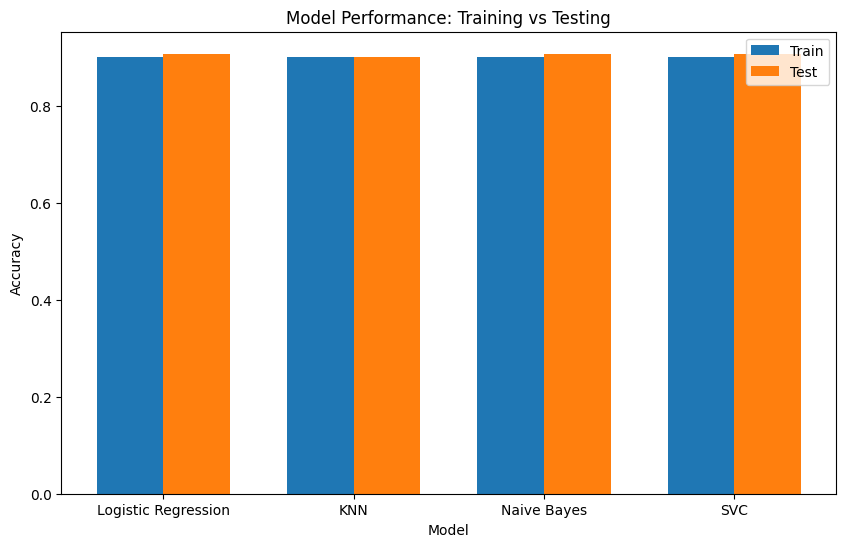



=============== medical ===============
Logistic Regression:
  Training Accuracy: 0.9127
  Testing Accuracy: 0.8903
  Model is performing well on both training and test data.

KNN:
  Training Accuracy: 0.9134
  Testing Accuracy: 0.8919
  Model is performing well on both training and test data.

Naive Bayes:
  Training Accuracy: 0.9127
  Testing Accuracy: 0.8903
  Model is performing well on both training and test data.

SVC:
  Training Accuracy: 0.9127
  Testing Accuracy: 0.8903
  Model is performing well on both training and test data.



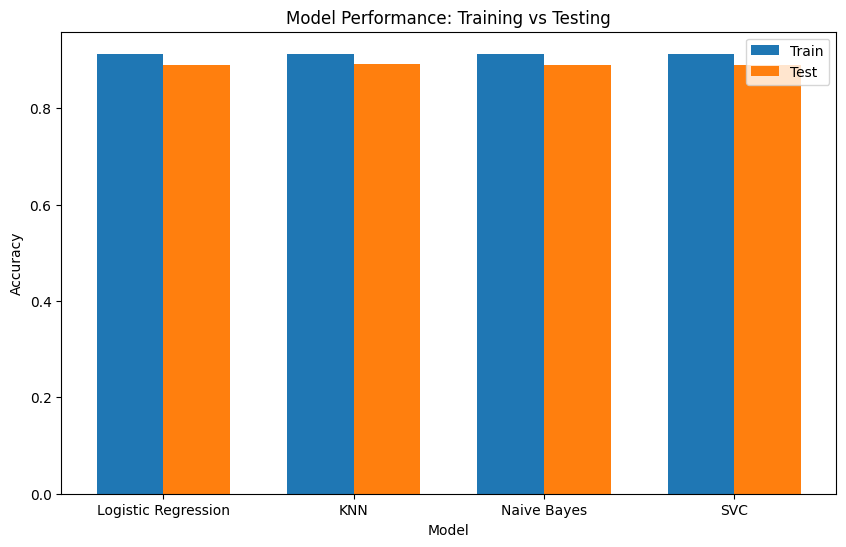



=============== others ===============
Logistic Regression:
  Training Accuracy: 0.8918
  Testing Accuracy: 0.9116
  Model is performing well on both training and test data.

KNN:
  Training Accuracy: 0.8918
  Testing Accuracy: 0.8977
  Model is performing well on both training and test data.

Naive Bayes:
  Training Accuracy: 0.8918
  Testing Accuracy: 0.9116
  Model is performing well on both training and test data.

SVC:
  Training Accuracy: 0.8918
  Testing Accuracy: 0.9116
  Model is performing well on both training and test data.



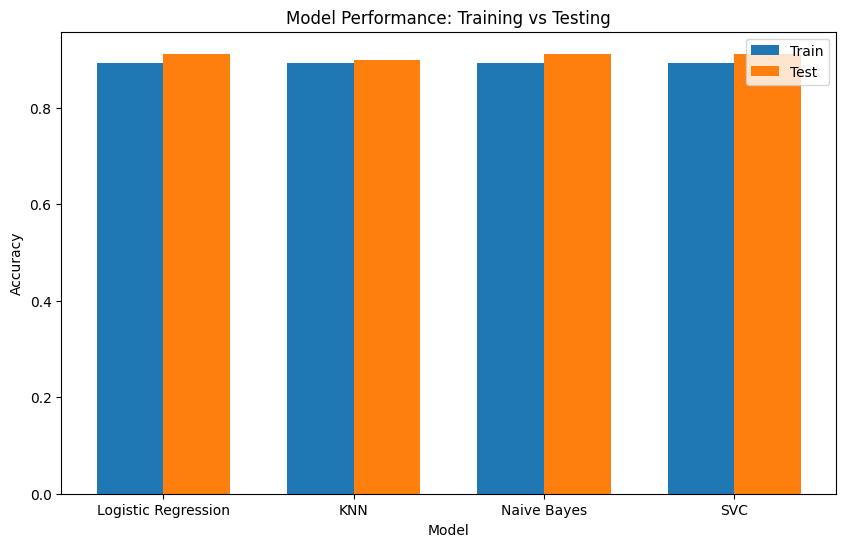

In [ ]:
features = ['Age', 'CGPA', 'Semester_Credit_Load', 'Anxiety_Score']
majors = ['business', 'engineering','law','medical','others']
depression_threshold = 4

for major in majors:
    print("="*15, major, "="*15)
    data = pd.read_csv(f'../Data/clean_df_{major}.csv')
    data.drop(['Course'], axis=1, inplace=True)
    data['Depression_Score'] = data['Depression_Score'].apply(lambda x: 1 if x > depression_threshold else 0)

    X = data[features]
    y = data['Depression_Score']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    test_model_fit(X_train, y_train, X_test, y_test)
    print("\n")
